# 3. Modelleme ve Değerlendirme

Bu notebook, makine öğrenmesi modellerinin kurulması, eğitilmesi, değerlendirilmesi ve hiperparametre optimizasyonunu içerir. —

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# 1. VERİ YÜKLEME VE HAZIRLIK

print("Veriler yükleniyor...")

# 1) Normal (Imbalanced) Eğitim Seti
X_train_raw_df = pd.read_csv("../data/processed/X_train_selected.csv")
y_train_raw_df = pd.read_csv("../data/processed/y_train_final.csv")

# 2) SMOTE (Balanced) Eğitim Seti (Bunu mutlaka yükleyelim!)
X_train_smote_df = pd.read_csv("../data/processed/X_train_smote.csv")
y_train_smote_df = pd.read_csv("../data/processed/y_train_smote.csv")

# 3) Validation ve Test Setleri
X_val_encoded = pd.read_csv("../data/processed/X_val_encoded.csv")
y_val_final = pd.read_csv("../data/processed/y_val_final.csv")["Loan_Status"].values.ravel()
X_test_encoded = pd.read_csv("../data/processed/X_test_encoded.csv")

# Feature listesini yükle
with open("../data/processed/final_feature_list.json", "r", encoding="utf-8") as f:
    final_features = json.load(f)

# VERİ SETLERİNİ HAZIRLA

# Set 1: Normal Veri (Sadece seçilen featurelar)
X_train = X_train_raw_df[final_features]
y_train = y_train_raw_df["Loan_Status"].values.ravel()

# Set 2: SMOTE Verisi (Sadece seçilen featurelar)
X_train_smote = X_train_smote_df[final_features]
y_train_smote = y_train_smote_df["Loan_Status"].values.ravel()

# Validation ve Test (Sadece seçilen featurelar)
X_val = X_val_encoded[final_features]
y_val = y_val_final
X_test = X_test_encoded[final_features]

print(f"Seçilen özellik sayısı: {len(final_features)}")
print("Veri boyutları:")
print(f"X_train (Normal): {X_train.shape}")
print(f"X_train_smote (SMOTE): {X_train_smote.shape}") 
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Veriler yükleniyor...
Seçilen özellik sayısı: 25
Veri boyutları:
X_train (Normal): (491, 25)
X_train_smote (SMOTE): (674, 25)
X_val: (123, 25)
X_test: (367, 25)


In [2]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# 2. YARDIMCI FONKSİYONLAR
# Model eğitimi ve değerlendirmesi için tekrar kullanılabilir fonksiyon.
# Bu sayede kod tekrarı önlendi ve modüler yapı sağlandı.

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    """
    Modeli eğitir ve validasyon seti üzerinde değerlendirir.
    
    Args:
        model: Eğitilecek sklearn modeli
        X_train: Eğitim veri seti (features)
        y_train: Eğitim hedef değişkeni
        X_val: Doğrulama veri seti (features)
        y_val: Doğrulama hedef değişkeni
        model_name: Modelin ismi (str)
        
    Returns:
        dict: Model performans metrikleri ve eğitilmiş model
    """
    print(f"--- {model_name} Eğitiliyor ---")
    
    # Modeli eğit
    model.fit(X_train, y_train)
    
    # Tahminler
    y_pred = model.predict(X_val)
    
    # Olasılıklar (ROC-AUC için)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
    else:
        y_proba = None
        
    # Metrikler
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba) if y_proba is not None else 0.0
    
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("-" * 30)
    
    return {
        "Model": model_name,
        "Accuracy": acc,
        "F1 Score": f1,
        "ROC-AUC": auc,
        "Trained_Model": model
    }

# Sonuçları ve modelleri saklamak için global değişkenler
all_results = []
trained_models = {}

In [3]:
from sklearn.linear_model import LogisticRegression

# 3.1. Logistic Regression
# Parametreler: max_iter=1000 (Orijinal ayar korundu)

lr_model = LogisticRegression(max_iter=1000, random_state=42)

lr_results = train_and_evaluate(lr_model, X_train, y_train, X_val, y_val, "Logistic Regression")
all_results.append(lr_results)
trained_models["Logistic Regression"] = lr_results["Trained_Model"]

--- Logistic Regression Eğitiliyor ---
Accuracy: 0.8537
F1 Score: 0.9032
ROC-AUC: 0.8492
------------------------------


In [4]:
from sklearn.ensemble import RandomForestClassifier

# 3.2. Random Forest

rf_model = RandomForestClassifier(random_state=42)

rf_results = train_and_evaluate(rf_model, X_train, y_train, X_val, y_val, "Random Forest")
all_results.append(rf_results)
trained_models["Random Forest"] = rf_results["Trained_Model"]

--- Random Forest Eğitiliyor ---
Accuracy: 0.8455
F1 Score: 0.8914
ROC-AUC: 0.8799
------------------------------


In [5]:
from sklearn.svm import SVC

# 3.3. Support Vector Machine (SVM)

# probability=True: ROC-AUC hesaplaması için gerekli
svm_model = SVC(probability=True, random_state=42)

svm_results = train_and_evaluate(svm_model, X_train, y_train, X_val, y_val, "Support Vector Machine")
all_results.append(svm_results)
trained_models["Support Vector Machine"] = svm_results["Trained_Model"]

--- Support Vector Machine Eğitiliyor ---
Accuracy: 0.8537
F1 Score: 0.9032
ROC-AUC: 0.8548
------------------------------


In [6]:
from sklearn.ensemble import GradientBoostingClassifier

# 3.4. Gradient Boosting (XGB)

xgb_model = GradientBoostingClassifier(random_state=42)

xgb_results = train_and_evaluate(xgb_model, X_train, y_train, X_val, y_val, "Gradient Boosting (XGB)")
all_results.append(xgb_results)
trained_models["Gradient Boosting (XGB)"] = xgb_results["Trained_Model"]

--- Gradient Boosting (XGB) Eğitiliyor ---
Accuracy: 0.8618
F1 Score: 0.9029
ROC-AUC: 0.9034
------------------------------


In [7]:
from sklearn.neighbors import KNeighborsClassifier

# 3.5. K-Neighbors (KNN)

knn_model = KNeighborsClassifier()

knn_results = train_and_evaluate(knn_model, X_train, y_train, X_val, y_val, "K-Neighbors (KNN)")
all_results.append(knn_results)
trained_models["K-Neighbors (KNN)"] = knn_results["Trained_Model"]

--- K-Neighbors (KNN) Eğitiliyor ---
Accuracy: 0.7967
F1 Score: 0.8663
ROC-AUC: 0.7389
------------------------------


In [8]:
# 4. SONUÇLARIN KARŞILAŞTIRILMASI

results_df = pd.DataFrame(all_results).drop(columns=["Trained_Model"])
results_df = results_df.sort_values(by="F1 Score", ascending=False)

print("=== MODEL PERFORMANS TABLOSU ===")
print(results_df)

=== MODEL PERFORMANS TABLOSU ===
                     Model  Accuracy  F1 Score   ROC-AUC
0      Logistic Regression  0.853659  0.903226  0.849226
2   Support Vector Machine  0.853659  0.903226  0.854799
3  Gradient Boosting (XGB)  0.861789  0.902857  0.903406
1            Random Forest  0.845528  0.891429  0.879876
4        K-Neighbors (KNN)  0.796748  0.866310  0.738854


=== MODELLERİN EĞİTİMİ BAŞLIYOR (NORMAL vs SMOTE) ===
--- Logistic Regression (Normal) Eğitiliyor ---
Accuracy: 0.8537
F1 Score: 0.9032
ROC-AUC: 0.8492
------------------------------
--- Logistic Regression (SMOTE) Eğitiliyor ---
Accuracy: 0.8293
F1 Score: 0.8772
ROC-AUC: 0.8498
------------------------------
--- Random Forest (Normal) Eğitiliyor ---
Accuracy: 0.8455
F1 Score: 0.8914
ROC-AUC: 0.8799
------------------------------
--- Random Forest (SMOTE) Eğitiliyor ---
Accuracy: 0.8455
F1 Score: 0.8902
ROC-AUC: 0.8526
------------------------------
--- Support Vector Machine (Normal) Eğitiliyor ---
Accuracy: 0.8537
F1 Score: 0.9032
ROC-AUC: 0.8548
------------------------------
--- Support Vector Machine (SMOTE) Eğitiliyor ---
Accuracy: 0.8130
F1 Score: 0.8686
ROC-AUC: 0.8307
------------------------------
--- Gradient Boosting (Normal) Eğitiliyor ---
Accuracy: 0.8618
F1 Score: 0.9029
ROC-AUC: 0.9034
------------------------------
--- Gradient Boosting (SMOTE) Eğitiliyor ---
Accuracy:

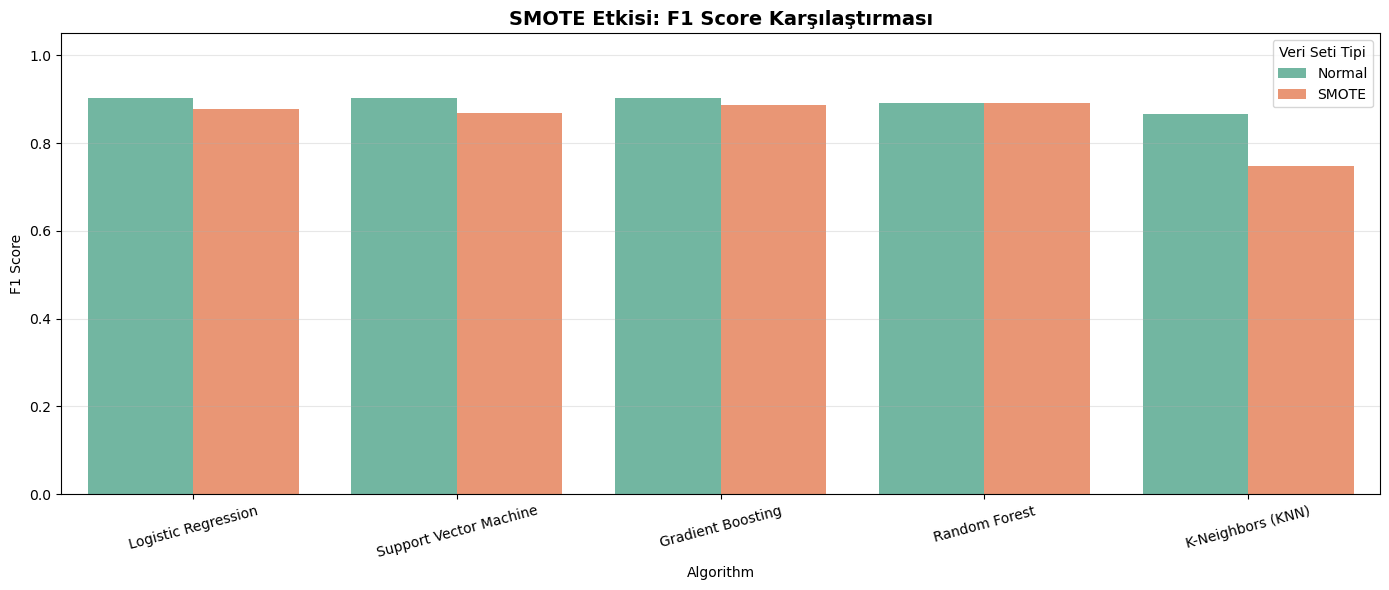


En Başarılı Konfigürasyon: Logistic Regression (Normal)


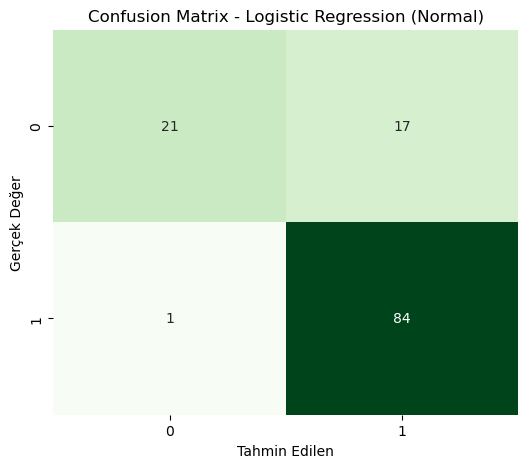

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3. BASELINE MODELLER (Normal vs SMOTE Karşılaştırmalı)

# Modelleri bir sözlükte tanımlıyoruz (Yönetimi kolay olsun)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "K-Neighbors (KNN)": KNeighborsClassifier()
}

# Veri setlerini tanımlıyoruz
datasets = {
    "Normal": (X_train, y_train),
    "SMOTE": (X_train_smote, y_train_smote)
}

all_results = []
trained_models = {}

print("=== MODELLERİN EĞİTİMİ BAŞLIYOR (NORMAL vs SMOTE) ===")

for model_name, model_inst in models.items():
    for data_type, (X_t, y_t) in datasets.items():
        
        # Modelin taze bir kopyasını al (önceki eğitimden etkilenmesin)
        from sklearn.base import clone
        current_model = clone(model_inst)
        
        # İsimlendirme: "Random Forest (Normal)" veya "Random Forest (SMOTE)"
        run_name = f"{model_name} ({data_type})"
        
        # Fonksiyonunu çağır (X_val ve y_val sabittir!)
        res = train_and_evaluate(current_model, X_t, y_t, X_val, y_val, run_name)
        
        # Sonuçlara 'Data Type' bilgisi ekle (Grafik için lazım olacak)
        res["Algorithm"] = model_name
        res["Data Type"] = data_type
        
        all_results.append(res)
        trained_models[run_name] = res["Trained_Model"]

# 4. SONUÇLARIN KARŞILAŞTIRILMASI

results_df = pd.DataFrame(all_results).drop(columns=["Trained_Model"])

# F1 Score'a göre sırala
results_df = results_df.sort_values(by="F1 Score", ascending=False)

print("\n=== GENEL PERFORMANS TABLOSU ===")
print(results_df[["Model", "Accuracy", "F1 Score", "ROC-AUC"]])

# 5. GÖRSELLEŞTİRME (Normal vs SMOTE Etkisi)

# F1 Score Karşılaştırması
plt.figure(figsize=(14, 6))
sns.barplot(
    data=results_df, 
    x="Algorithm", 
    y="F1 Score", 
    hue="Data Type", 
    palette="Set2"
)
plt.title("SMOTE Etkisi: F1 Score Karşılaştırması", fontsize=14, fontweight="bold")
plt.ylim(0, 1.05)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.legend(title="Veri Seti Tipi")
plt.tight_layout()
plt.show()

# En iyi modelin Confusion Matrix'i
best_run_name = results_df.iloc[0]["Model"]
print(f"\nEn Başarılı Konfigürasyon: {best_run_name}")

best_model = trained_models[best_run_name]
y_pred_best = best_model.predict(X_val)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_pred_best), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title(f"Confusion Matrix - {best_run_name}", fontsize=12)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.show()

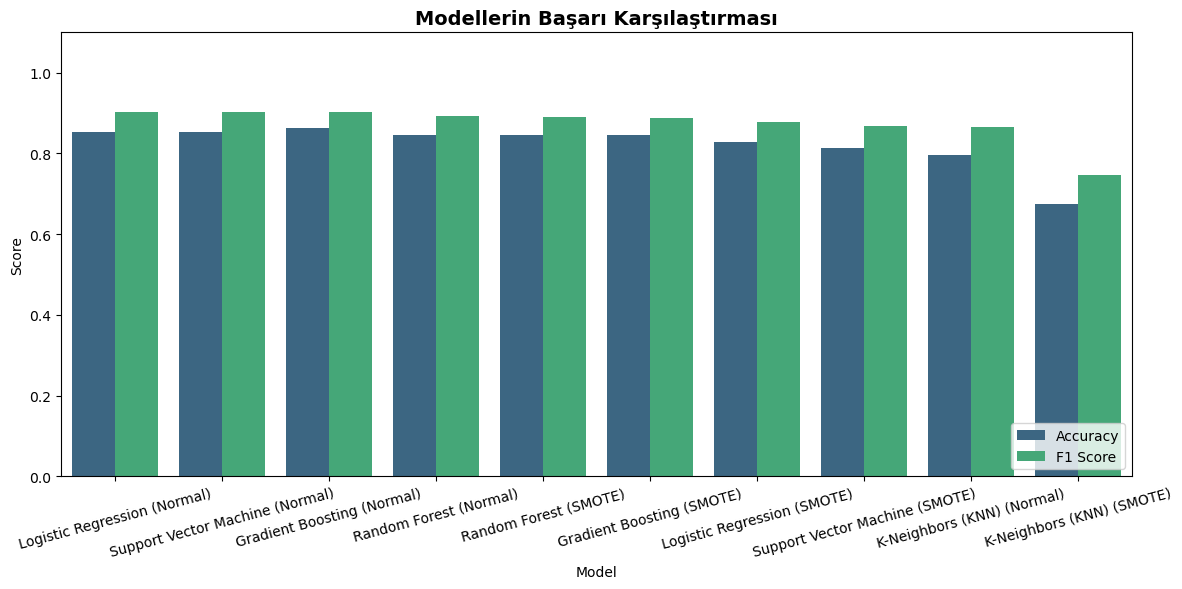


En İyi Model (F1 Skoruna Göre): Logistic Regression (Normal)


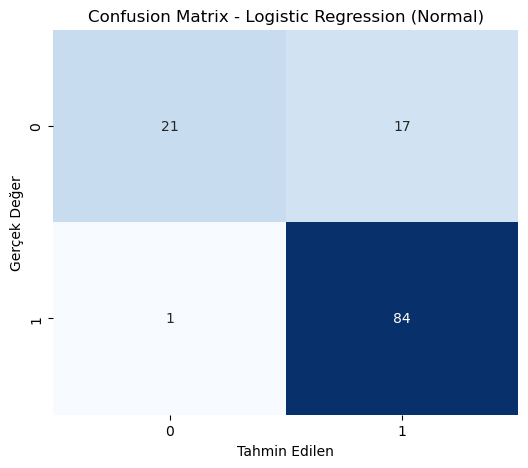

In [10]:
# 5. GÖRSELLEŞTİRME

plt.figure(figsize=(12, 6))
melted_results = results_df.melt(id_vars="Model", value_vars=["Accuracy", "F1 Score"], var_name="Metric", value_name="Score")
sns.barplot(data=melted_results, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Modellerin Başarı Karşılaştırması", fontsize=14, fontweight="bold")
plt.ylim(0, 1.1)
plt.xticks(rotation=15)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# En iyi modelin Confusion Matrix'i
best_model_name = results_df.iloc[0]["Model"]
print(f"\nEn İyi Model (F1 Skoruna Göre): {best_model_name}")

best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_val)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_pred_best), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix - {best_model_name}", fontsize=12)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.show()


=== HİPERPARAMETRE OPTİMİZASYONU BAŞLIYOR (5 MODEL) ===
Yöntem: GridSearchCV (5-Katlı Cross Validation ile)
Kullanılan Veri Seti: SMOTE Uygulanmış Dengeli Veri

>>> 'Logistic Regression' için optimizasyon yapılıyor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
   En İyi Skor (F1): 0.7601
   En İyi Parametreler: {'C': 0.1, 'solver': 'liblinear'}

>>> 'Random Forest' için optimizasyon yapılıyor...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
   En İyi Skor (F1): 0.8558
   En İyi Parametreler: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

>>> 'Support Vector Machine' için optimizasyon yapılıyor...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
   En İyi Skor (F1): 0.7957
   En İyi Parametreler: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

>>> 'Gradient Boosting' için optimizasyon yapılıyor...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
   En İyi Skor (F1): 0.8177
   En İyi Para

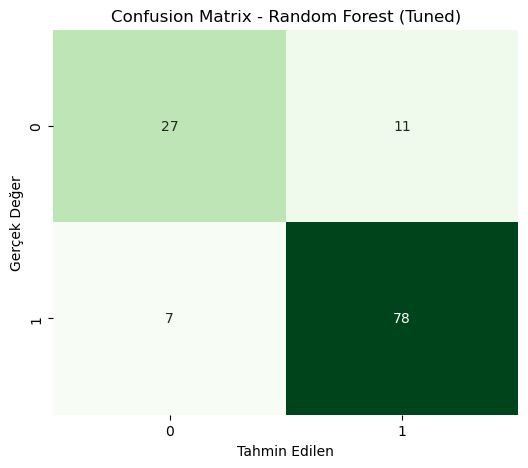

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 11. HİPERPARAMETRE OPTİMİZASYONU (TÜM MODELLER İÇİN)
print("\n=== HİPERPARAMETRE OPTİMİZASYONU BAŞLIYOR (5 MODEL) ===")
print("Yöntem: GridSearchCV (5-Katlı Cross Validation ile)")
print("Kullanılan Veri Seti: SMOTE Uygulanmış Dengeli Veri")

# 5 Modelin tamamı için parametre aralıkları
model_params = {
    # 1. Logistic Regression
    "Logistic Regression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            "C": [0.01, 0.1, 1, 10],              # Regularizasyon gücü
            "solver": ["liblinear", "lbfgs"]      # Farklı çözücüler
        }
    },

    # 2. Random Forest
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5],
            "class_weight": ["balanced", None]
        }
    },

    # 3. Support Vector Machine (SVM)
    "Support Vector Machine": {
        # probability=True: ROC-AUC için gerekli
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],                    # Hata ceza parametresi
            "kernel": ["linear", "rbf"],          # Çekirdek tipi
            "gamma": ["scale", "auto"]            # Kernel katsayısı
        }
    },

    # 4. Gradient Boosting
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0]
        }
    },

    # 5. K-Neighbors (KNN)
    "K-Neighbors (KNN)": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],          # Komşu sayısı
            "weights": ["uniform", "distance"],   # Ağırlıklandırma
            "metric": ["euclidean", "manhattan"]  # Mesafe ölçümü
        }
    }
}

best_models = {}

for model_name, mp in model_params.items():
    print(f"\n>>> '{model_name}' için optimizasyon yapılıyor...")
    
    # GridSearchCV Tanımlama
    clf = GridSearchCV(
        mp["model"], 
        mp["params"], 
        cv=5, 
        scoring='f1', 
        n_jobs=-1,  
        verbose=1
    )
    
    # SMOTE verisi ile eğit
    try:
        clf.fit(X_train_smote, y_train_smote)
    except NameError:
        print("UYARI: X_train_smote bulunamadı, normal X_train kullanılıyor.")
        clf.fit(X_train, y_train)
    
    print(f"   En İyi Skor (F1): {clf.best_score_:.4f}")
    print(f"   En İyi Parametreler: {clf.best_params_}")
    
    # En iyi modeli kaydet
    best_models[model_name] = clf.best_estimator_

# 12. OPTİMİZE EDİLMİŞ MODELLERİN TEST PERFORMANSI


print("\n=== OPTİMİZE EDİLMİŞ MODELLERİN DOĞRULAMA (VAL) SONUÇLARI ===")

final_results = []

for name, model in best_models.items():
    # Validation seti üzerinde tahmin
    y_pred = model.predict(X_val)
    
    # Metrikler
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    final_results.append({
        "Model": name + " (Tuned)",
        "Accuracy": acc,
        "F1 Score": f1
    })

# Karşılaştırma Tablosunu Güncelle
df_final = pd.DataFrame(final_results).sort_values(by="F1 Score", ascending=False)
print("\n", df_final)

# En iyi modelin Confusion Matrix'i (Validation Seti)
if not df_final.empty:
    best_tuned_name = df_final.iloc[0]["Model"]
    # İsimdeki " (Tuned)" ekini kaldırıp model sözlüğünden çekiyoruz
    original_name = best_tuned_name.replace(" (Tuned)", "")
    best_tuned_model = best_models[original_name]

    print(f"\nSeçilen Final Model: {best_tuned_name}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_val, best_tuned_model.predict(X_val)), 
                annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title(f"Confusion Matrix - {best_tuned_name}", fontsize=12)
    plt.xlabel("Tahmin Edilen")
    plt.ylabel("Gerçek Değer")
    plt.show()

c:\Users\murat\.conda\envs\loan-ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



=== AÇIKLANABİLİR YZ (SHAP) ANALİZİ BAŞLIYOR ===
✓ SHAP değerleri hesaplandı.

Grafik 1: Özelliklerin Global Etkisi (Summary Plot)


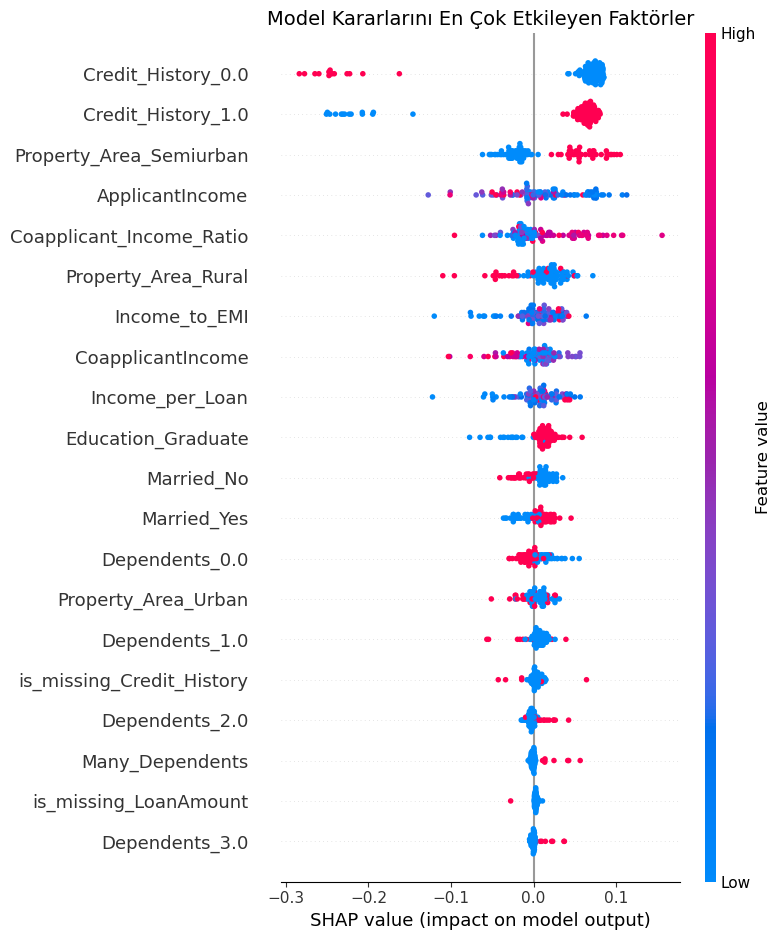


Grafik 2: Örnek Müşteri Analizi


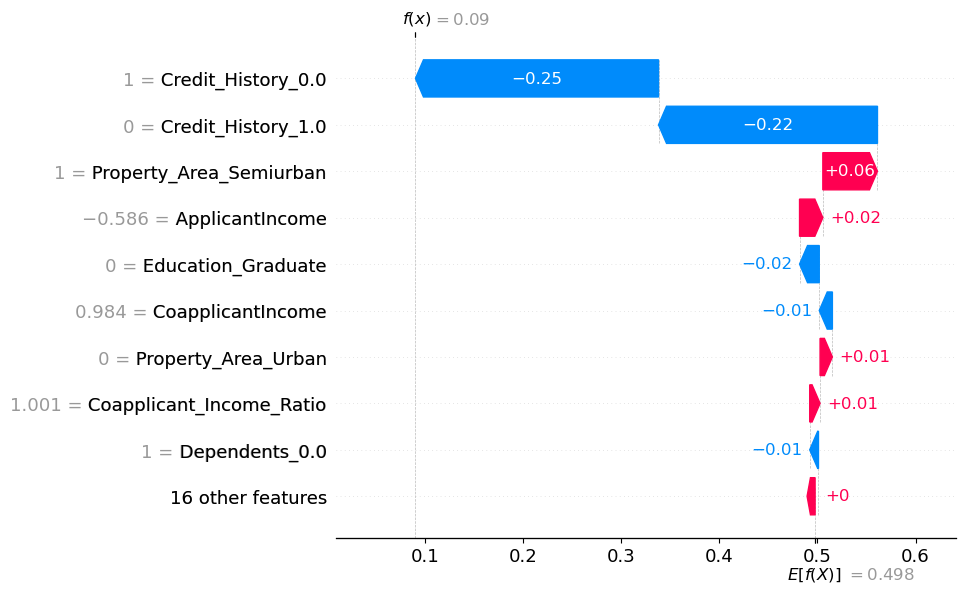

In [12]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # sample işlemi için gerekebilir

# 13. AÇIKLANABİLİR YAPAY ZEKA (SHAP ANALİZİ) - FINAL FIX

print("\n=== AÇIKLANABİLİR YZ (SHAP) ANALİZİ BAŞLIYOR ===")

# 1. Veri Hazırlığı
# DÜZELTME: Sütun isimlerini final_features listesinden veya X_train'den alıyoruz
try:
    train_cols = final_features
except NameError:
    # Eğer final_features tanımlı değilse X_train'den al
    train_cols = X_train.columns.tolist()

# X_val_encoded DataFrame'inden örneklem alıyoruz
X_shap_sample = X_val_encoded.sample(n=100, random_state=42)

# Sadece eğitimde kullanılan sütunları seçiyoruz (Sırası da aynı olmalı)
X_shap_sample = X_shap_sample[train_cols] 

# 2. Explainer Oluşturma
try:
    explainer = shap.TreeExplainer(best_tuned_model)
    # check_additivity=False hatayı engeller
    shap_values = explainer.shap_values(X_shap_sample, check_additivity=False)
except Exception as e:
    print(f"TreeExplainer hatası ({e}), KernelExplainer deneniyor...")
    # KernelExplainer biraz yavaş çalışabilir
    explainer = shap.KernelExplainer(best_tuned_model.predict_proba, X_shap_sample)
    shap_values = explainer.shap_values(X_shap_sample)

print("✓ SHAP değerleri hesaplandı.")

# 3. Doğru Sınıfı (Class 1 - Loan=Y) Seçme Mantığı
# Durum A: Liste ise (Genelde Random Forest) -> [Class0, Class1]
if isinstance(shap_values, list):
    shap_vals_target = shap_values[1]
    base_val = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value

# Durum B: 3 Boyutlu Array ise (N, Features, Classes)
elif len(np.shape(shap_values)) == 3:
    shap_vals_target = shap_values[:, :, 1] # Sadece Class 1'i al
    base_val = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

# Durum C: Zaten doğru boyuttaysa (Sadece binary output varsa)
else:
    shap_vals_target = shap_values
    base_val = explainer.expected_value

# GRAFİK 1: GLOBAL ÖNEM (Summary Plot)
print("\nGrafik 1: Özelliklerin Global Etkisi (Summary Plot)")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_vals_target, X_shap_sample, show=False)
plt.title("Model Kararlarını En Çok Etkileyen Faktörler", fontsize=14)
plt.tight_layout()
plt.show()

# GRAFİK 2: YEREL AÇIKLAMA (Waterfall Plot)
print(f"\nGrafik 2: Örnek Müşteri Analizi")

sample_idx = 0
# Tek bir kişinin verilerini al
single_shap_values = shap_vals_target[sample_idx]
single_data = X_shap_sample.iloc[sample_idx].values

# Eğer hala 2 boyutluysa düzleştir
if len(single_shap_values.shape) > 1:
    single_shap_values = single_shap_values.reshape(-1)

# Explanation objesi oluştur
exp = shap.Explanation(
    values=single_shap_values,
    base_values=base_val,
    data=single_data,
    feature_names=train_cols
)

# Çizim
try:
    shap.plots.waterfall(exp)
except Exception as e:
    print(f"Waterfall çizilemedi ({e}). Alternatif bar plot çiziliyor.")
    shap.plots.bar(exp)